In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel

In [25]:
df_uk_accidents = pd.read_csv('data/uk_accidents.csv', encoding = 'unicode_escape')
df_uk_vehicles = pd.read_csv('data/uk_vehicles.csv', encoding = 'unicode_escape')
df_uk_casualties = pd.read_csv('data/uk_casualties.csv', encoding = 'unicode_escape')
df_uk_makes = pd.read_csv('data/Vehicle_Information.csv', usecols = [0, 10, 11, 19], encoding = 'unicode_escape')
df_ratings = pd.read_csv('all_ratings.csv') 

/Users/jyoti/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/jyoti/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
# Appending makes and models to the UK vehicles DF
if 'Vehicle_Make' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_makes, on = ['Accident_Index', 'Vehicle_Reference'], how='left')
    
# Rename vehicle make, model to follow the same convention
df_uk_vehicles.rename(columns={'make': 'Vehicle_Make', 'model': 'Vehicle_Model'}, inplace = True)

# Mapping numeric values to corresponding text
df_uk_vehicles_map = {
    'Sex_of_Driver': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Age_Band_of_Driver': {-1: np.nan, 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75'}, 
    'Vehicle_Make': {'MISSING': np.nan},
    'Vehicle_Model': {'MISSING': np.nan},
    'Age_of_Vehicle': {-1: np.nan},
    '1st_Point_of_Impact': {-1: np.nan, 1: 'Front', 2: 'Back', 3: 'Offside', 4: 'Nearside'},
    'Vehicle_Manoeuvre': {-1: np.nan, 1: 'Reversing', 2: 'Parked', 3: 'Waiting to go - held up', 4: 'Slowing or stopping', 5: 'Moving off', 6: 'U-turn', 7: 'Turning left', 8: 'Waiting to turn left', 9: 'Turning right', 10: 'Waiting to turn right', 11: 'Changing lane to left', 12: 'Changing lane to right', 13: 'Overtaking moving vehicle – offside', 14: 'Overtaking static vehicle - offside', 15: 'Overtaking - nearside', 16: 'Going ahead left-hand bend', 17: 'Going ahead right-hand bend', 18: 'Going ahead other'},
    'Vehicle_Type': {-1: np.nan, 90: np.nan, 1: 'Pedal cycle', 2: 'Motorcycle <=50cc', 3: 'Motorcycle <=125cc', 4: 'Motorcycle 125cc-500cc', 5: 'Motorcycle >500cc', 8: 'Taxi/Private hire car', 9: 'Car', 10: 'Minibus (8-16 seats)', 11: 'Bus (>=17 seats)', 16: 'Ridden horse', 17: 'Agricultural vehicle', 18: 'Tram', 19: 'Van <=3.5 t.', 20: 'Goods 3.5t.-7.5t', 21: 'Goods >=7.5 t.', 22: 'Mobility scooter', 23: 'Electric motorcycle', 97: 'Motorcycle - unknown cc', 98: 'Goods vehicle - unknown weight'},
    'Vehicle_Location-Restricted_Lane': {-1: np.nan, 0: 'On main carriageway - not in restricted lane', 1: 'Tram/Light rail track', 2: 'Bus lane', 3:	'Busway (including guided busway)', 4: 'Cycle lane (on main carriageway)', 5: 'Cycleway or shared use footway (not part of  main carriageway)', 6: 'On lay-by or hard shoulder', 7:	'Entering lay-by or hard shoulder', 8:	'Leaving lay-by or hard shoulder', 9: 'Footway (pavement)', 10:	'Not on carriageway'},
    'Junction_Location': {-1: np.nan, 0: 'Not at or within 20 metres of junction', 1:	'Approaching junction or waiting/parked at junction approach', 2:	'Cleared junction or waiting/parked at junction exit', 3:	'Leaving roundabout', 4: 'Entering roundabout', 5: 'Leaving main road', 6: 'Entering main road', 7:	'Entering from slip road', 8:	'Mid Junction - on roundabout or on main road'},
    'Skidding_and_Overturning': {-1: np.nan, 0: 'None', 1: 'Skidded', 2: 'Skidded and overturned', 3:	'Jackknifed', 4: 'Jackknifed and overturned', 5: 'Overturned'},
    'Hit_Object_in_Carriageway': {-1: np.nan, 11: np.nan, 0: 'None', 1: 'Previous accident', 2: 'Road works', 4: 'Parked vehicle', 5:	'Bridge (roof)', 6:	'Bridge (side)', 7:	'Bollard or refuge', 8:	'Open door of vehicle', 9: 'Central island of roundabout', 10: 'Kerb', 12: 'Any animal (except ridden horse)'}, 
    'Vehicle_Leaving_Carriageway': {-1: np.nan, 0: 'Did not leave carriageway', 1: 'Nearside', 2:	'Nearside and rebounded', 3: 'Straight ahead at junction', 4: 'Offside on to central reservation', 5:	'Offside on to centrl res + rebounded', 6: 'Offside - crossed central reservation', 7: 'Offside', 8: 'Offside and rebounded'},
    'Hit_Object_off_Carriageway': {-1: np.nan, 10: np.nan, 0: 'None', 1: 'Road sign or traffic signal', 2: 'Lamp post', 3: 'Telegraph or electricity pole', 4: 'Tree', 5:	'Bus stop or bus shelter', 6:	'Central crash barrier', 7:	'Near/Offside crash barrier', 8: 'Submerged in water', 9: 'Entered ditch', 11: 'Wall or fence'},
    'Journey_Purpose_of_Driver' : {-1: np.nan, 5: np.nan, 6: np.nan, 15: np.nan, 1:	'Journey as part of work', 2:	'Commuting to/from work', 3: 'Taking pupil to/from school', 4: 'Pupil riding to/from school'},
    'Age_of_Driver': {-1: np.nan},
    'Engine_Capacity_(CC)': {-1: np.nan},
    'Propulsion_Code': {-1: np.nan, 1: 'Petrol', 2: 'Heavy oil', 3: 'Electric', 4:	'Steam', 5:	'Gas', 6:	'Petrol/Gas (LPG)', 7: 'Gas/Bi-fuel', 8: 'Hybrid electric', 9: 'Gas Diesel', 10: 'New fuel technology', 11:	'Fuel cells', 12:	'Electric diesel'},
    'Driver_Home_Area_Type': {-1: np.nan, 1: 'Urban area', 2:	'Small town', 3: 'Rural'}
}

df_uk_accidents_map = {
    'Accident_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Weather_Conditions': {-1: np.nan, 8: np.nan, 9: np.nan, 1: 'Fine no high winds', 2: 'Raining no high winds', 3: 'Snowing no high winds', 4: 'Fine + high winds', 5: 'Raining + high winds', 6: 'Snowing + high winds', 7: 'Fog or mist'},
    'Light_Conditions': {-1: np.nan, 1: 'Daylight', 4: 'Darkness - lights lit', 5: 'Darkness - lights unlit', 6: 'Darkness - no lighting', 7: 'Darkness - lighting unknown'},
    'Police_Force': {1:	'Metropolitan Police', 3: 'Cumbria', 4:	'Lancashire', 5: 'Merseyside', 6:	'Greater Manchester', 7: 'Cheshire', 10: 'Northumbria', 11:	'Durham', 12:	'North Yorkshire', 13: 'West Yorkshire', 14: 'South Yorkshire', 16:	'Humberside', 17:	'Cleveland', 20: 'West Midlands', 21:	'Staffordshire', 22: 'West Mercia', 23:	'Warwickshire', 30: 'Derbyshire', 31:	'Nottinghamshire', 32: 'Lincolnshire', 33:	'Leicestershire', 34:	'Northamptonshire', 35:	'Cambridgeshire', 36:	'Norfolk', 37: 'Suffolk', 40:	'Bedfordshire', 41:	'Hertfordshire', 42: 'Essex', 43:	'Thames Valley', 44: 'Hampshire', 45:	'Surrey', 46:	'Kent', 47:	'Sussex', 48:	'City of London', 50:	'Devon and Cornwall', 52:	'Avon and Somerset', 53: 'Gloucestershire', 54:	'Wiltshire', 55: 'Dorset', 60: 'North Wales', 61:	'Gwent', 62: 'South Wales', 63:	'Dyfed-Powys', 91: 'Northern', 92: 'Grampian', 93: 'Tayside', 94:	'Fife', 95:	'Lothian and Borders', 96: 'Central', 97:	'Strathclyde', 98: 'Dumfries and Galloway'},
    'Day_of_Week': {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'},
    '1st_Road_Class': {6: np.nan, 1: 'Motorway', 2: 'A(M)', 3:	'A', 4:	'B', 5: 'C'},
    'Road_Type': {-1: np.nan, 9: np.nan, 1: 'Roundabout', 2: 'One way street', 3: 'Dual carriageway', 6: 'Single carriageway', 7: 'Slip road', 12: 'One way street/Slip road'},
    'Junction_Detail': {-1: np.nan, 9: np.nan, 0: 'Not at junction or within 20 metres', 1:	'Roundabout', 2: 'Mini-roundabout', 3: 'T or staggered junction', 5: 'Slip road', 6: 'Crossroads', 7: 'More than 4 arms (not roundabout)', 8:	'Private drive or entrance'},
    'Junction_Control': {-1: np.nan, 0:	'Not at junction or within 20 metres', 1:	'Authorised person', 2:	'Auto traffic signal', 3:	'Stop sign', 4:	'Give way or uncontrolled'},
    '2nd_Road_Class': {-1: np.nan, 6: np.nan, 0: 'Not at junction or within 20 metres', 1: 'Motorway', 2:	'A(M)', 3: 'A', 4: 'B',	5: 'C'},
    'Pedestrian_Crossing-Human_Control': {-1: np.nan, 0: 'None within 50 metres', 1: 'Control by school crossing patrol', 2: 'Control by other authorised person'},
    'Pedestrian_Crossing-Physical_Facilities': {-1: np.nan, 0: 'No physical crossing facilities within 50 metres', 1: 'Zebra', 4:	'Pelican, puffin, toucan or similar non-junction pedestrian light crossing', 5:	'Pedestrian phase at traffic signal junction', 7:	'Footbridge or subway', 8: 'Central refuge'},
    'Road_Surface_Conditions': {-1: np.nan, 1: 'Dry', 2: 'Wet or damp', 3: 'Snow', 4:	'Frost or ice', 5: 'Flood over 3cm. deep', 6: 'Oil or diesel', 7:	'Mud'},
    'Special_Conditions_at_Site': {-1: np.nan, 0:	'None', 1: 'Auto traffic signal - out', 2: 'Auto signal part defective', 3:	'Road sign or marking defective or obscured', 4: 'Roadworks', 5: 'Road surface defective', 6:	'Oil or diesel', 7: 'Mud'},
    'Carriageway_Hazards': {-1: np.nan, 0: 'None', 1: 'Vehicle load on road', 2: 'Other object on road', 3:	'Previous accident', 4:	'Dog on road', 5:	'Other animal on road', 6: 'Pedestrian in carriageway - not injured', 7: 'Any animal in carriageway (except ridden horse)'},
    'Urban_or_Rural_Area': {3: np.nan, 1: 'Urban', 2:	'Rural'},
    'Did_Police_Officer_Attend_Scene_of_Accident': {-1: np.nan, 1: 'Yes', 2: 'No', 3: 'No - accident was reported using a self completion  form (self rep only)'}
}

df_uk_casualties_map = {
    'Casualty_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Sex_of_Casualty': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Casualty_Class': {-1: np.nan, 1: 'Driver or rider', 2: 'Passenger', 3: 'Pedestrian'},
    'Age_of_Casualty': {-1: np.nan },
    'Age_Band_of_Casualty': {-1: np.nan, 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75'},
    'Pedestrian_Location': {-1: np.nan, 10: np.nan, 0: 'Not a Pedestrian', 1:	'Crossing on pedestrian crossing facility', 2: 'Crossing in zig-zag approach lines', 3: 'Crossing in zig-zag exit lines', 4: 'Crossing elsewhere within 50m. of pedestrian crossing', 5: 'In carriageway, crossing elsewhere', 6:	'On footway or verge', 7:	'On refuge, central island or central reservation', 8: 'In centre of carriageway - not on refuge, island or central reservation', 9: 'In carriageway, not crossing'},
    'Pedestrian_Movement': {-1: np.nan, 9: np.nan, 0:	'Not a Pedestrian', 1: 'Crossing from driver nearside', 2: 'Crossing from nearside - masked by parked or stationary vehicle', 3: 'Crossing from driver offside', 4: 'Crossing from offside - masked by  parked or stationary vehicle', 5: 'In carriageway, stationary - not crossing  (standing or playing)', 6: 'In carriageway, stationary - not crossing  (standing or playing) - masked by parked or stationary vehicle', 7: 'Walking along in carriageway, facing traffic', 8:	'Walking along in carriageway, back to traffic'},
    'Car_Passenger': {-1: np.nan, 0: 'Not car passenger', 1: 'Front seat passenger', 2:	'Rear seat passenger'},
    'Bus_or_Coach_Passenger': {-1: np.nan, 0: 'Not a bus or coach passenger', 1: 'Boarding', 2:	'Alighting', 3:	'Standing passenger', 4: 'Seated passenger'},
    'Pedestrian_Road_Maintenance_Worker': {-1: np.nan, 2: np.nan, 0: 'No / Not applicable', 1: 'Yes'},
    'Casualty_Type': {-1:np.nan, 0:	'Pedestrian', 1: 'Cyclist', 2: 'Motorcycle 50cc and under rider or passenger', 3: 'Motorcycle 125cc and under rider or passenger', 4:	'Motorcycle over 125cc and up to 500cc rider or  passenger', 5:	'Motorcycle over 500cc rider or passenger', 8: 'Taxi/Private hire car occupant', 9:	'Car occupant', 10:	'Minibus (8 - 16 passenger seats) occupant', 11: 'Bus or coach occupant (17 or more pass seats)', 16:	'Horse rider', 17: 'Agricultural vehicle occupant', 18:	'Tram occupant', 19: 'Van / Goods vehicle (3.5 tonnes mgw or under) occupant', 20: 'Goods vehicle (over 3.5t. and under 7.5t.) occupant', 21:	'Goods vehicle (7.5 tonnes mgw and over) occupant', 22:	'Mobility scooter rider', 23:	'Electric motorcycle rider or passenger', 90:	'Other vehicle occupant', 97:	'Motorcycle - unknown cc rider or passenger', 98: 'Goods vehicle (unknown weight) occupant'}
}

for key in df_uk_vehicles_map:
    for old_value in df_uk_vehicles_map[key]:
        df_uk_vehicles[key] = df_uk_vehicles[key].replace(old_value, df_uk_vehicles_map[key][old_value])
for key in df_uk_accidents_map:
    for old_value in df_uk_accidents_map[key]:
        df_uk_accidents[key] = df_uk_accidents[key].replace(old_value, df_uk_accidents_map[key][old_value])
for key in df_uk_casualties_map:
    for old_value in df_uk_casualties_map[key]:
        df_uk_casualties[key] = df_uk_casualties[key].replace(old_value, df_uk_casualties_map[key][old_value])

# Converting UK Accident_Index to string
df_uk_vehicles.Accident_Index = df_uk_vehicles.Accident_Index.astype(str)
df_uk_accidents.Accident_Index = df_uk_accidents.Accident_Index.astype(str)
df_uk_casualties.Accident_Index = df_uk_casualties.Accident_Index.astype(str)

# Converting UK number columns to floats
df_uk_vehicles.Age_of_Vehicle = df_uk_vehicles.Age_of_Vehicle.astype(float)

# Calculating vehicle year from age_of_vehicle and accident date
if 'Vehicle_Year' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_accidents[['Accident_Index','Date']], on = ['Accident_Index'], how='left')
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles.Date.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'].astype(float)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'] - df_uk_vehicles.Age_of_Vehicle  
    
# Dropping unneccessary columns
df_uk_vehicles.drop(columns = ['Date', 'Towing_and_Articulation', 'Was_Vehicle_Left_Hand_Drive?', 'Driver_IMD_Decile', 'Vehicle_IMD_Decile'], inplace = True, errors = 'ignore')
df_uk_accidents.drop(columns = ['Local_Authority_(District)', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location'], inplace = True, errors = 'ignore')
df_uk_casualties.drop(columns = ['Casualty_Home_Area_Type', 'Casualty_IMD_Decile'], inplace = True, errors = 'ignore')

In [27]:
cols = ['OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 
        'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'ROLLOVER_STARS', 'ROLLOVER_STARS_2', 'ROLLOVER_POSSIBILITY',
        'ROLLOVER_POSSIBILITY_2', 'SIDE_POLE_STARS', 'MODEL_YR', 'MAKE', 'MODEL']
rating_cols = ['OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 
                'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'ROLLOVER_STARS', 'ROLLOVER_STARS_2', 'SIDE_POLE_STARS']
df_rating = df_ratings[cols]
df_rating = df_rating.replace({'Not Rated': np.nan})
df_rating[rating_cols] = df_rating[rating_cols].astype(float)
    
df_rating['OVERALL_STARS'].fillna(round(df_rating[rating_cols].mean(axis=1), 0), inplace=True)
df_rating['OVERALL_FRNT_STARS'].fillna(round(df_rating[['FRNT_DRIV_STARS', 'FRNT_PASS_STARS']].mean(axis=1), 0), 
                                       inplace=True)
df_rating['OVERALL_SIDE_STARS'].fillna(round(df_rating[['SIDE_DRIV_STARS', 'SIDE_PASS_STARS']].mean(axis=1), 0), 
                                       inplace=True)

In [28]:
# Merge data
df = df_uk_accidents[['Accident_Index', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 
                    'Date', 'Day_of_Week', 'Time', '1st_Road_Class', 'Road_Type', 'Speed_limit', 'Light_Conditions',
                    'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 
                    'Carriageway_Hazards', 'Urban_or_Rural_Area']]
df_veh = df_uk_vehicles[['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type', 'Vehicle_Manoeuvre', 
                        'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
                        '1st_Point_of_Impact', 'Engine_Capacity_(CC)', 'Propulsion_Code', 'Age_of_Vehicle',
                        'Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year','Sex_of_Driver', 'Age_Band_of_Driver']]
df_cas = df_uk_casualties[['Accident_Index', 'Vehicle_Reference', 'Casualty_Reference', 'Casualty_Class', 'Car_Passenger']]
df = pd.merge(df, df_veh, on=['Accident_Index'], how='left')
df = pd.merge(df, df_cas, on=['Accident_Index', 'Vehicle_Reference'], how='left')
df = df.rename(columns={'Vehicle_Model': 'MODEL', 'Vehicle_Make': 'MAKE', 'Vehicle_Year': 'MODEL_YR'})
df_stars = df_rating[['MODEL_YR', 'MAKE', 'MODEL', 'OVERALL_STARS', 'OVERALL_FRNT_STARS', 'OVERALL_SIDE_STARS']]
df = pd.merge(df, df_stars, on=['MODEL', 'MAKE', 'MODEL_YR'], how='left')
df.keys()

Index(['Accident_Index', 'Accident_Severity', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', '1st_Road_Class',
       'Road_Type', 'Speed_limit', 'Light_Conditions', 'Weather_Conditions',
       'Road_Surface_Conditions', 'Special_Conditions_at_Site',
       'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Vehicle_Reference',
       'Vehicle_Type', 'Vehicle_Manoeuvre', 'Skidding_and_Overturning',
       'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Engine_Capacity_(CC)', 'Propulsion_Code',
       'Age_of_Vehicle', 'MAKE', 'MODEL', 'MODEL_YR', 'Sex_of_Driver',
       'Age_Band_of_Driver', 'Casualty_Reference', 'Casualty_Class',
       'Car_Passenger', 'OVERALL_STARS', 'OVERALL_FRNT_STARS',
       'OVERALL_SIDE_STARS'],
      dtype='object')

In [29]:
df_uk = df[['Accident_Severity', 'Number_of_Vehicles','Number_of_Casualties', 
            'Day_of_Week','1st_Road_Class', 'Road_Type', 'Speed_limit', 'Light_Conditions', 
            'Weather_Conditions','Road_Surface_Conditions', 'Special_Conditions_at_Site',
            'Carriageway_Hazards', 'Urban_or_Rural_Area',
            'Vehicle_Type', 'Vehicle_Manoeuvre', 'Skidding_and_Overturning',
            'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
            '1st_Point_of_Impact', 'Engine_Capacity_(CC)', 'Propulsion_Code',
            'Age_of_Vehicle', 'Sex_of_Driver', 'Age_Band_of_Driver']]
df_uk = df_uk.dropna()

In [59]:
df_uk.shape

(1786626, 24)

## Random Forest - all 3 classes - unbalanced

In [20]:
c = Counter(df_uk['Accident_Severity'])
[(i, c[i] / len(df_uk['Accident_Severity']) * 100.0) for i in c]

[('Fatal', 1.8799121920312367),
 ('Slight', 84.52261413412768),
 ('Serious', 13.597473673841085)]

In [31]:
df_rf_3 = df_uk.copy()
# some modifications for label encoding
df_rf_3['Speed_limit'] = df_rf_3['Speed_limit'].astype(int)
df_rf_3['Engine_Capacity_(CC)'] = df_rf_3['Engine_Capacity_(CC)'].astype(int)
df_rf_3['Age_of_Vehicle'] = df_rf_3['Age_of_Vehicle'].astype(int)
df_rf_3['1st_Point_of_Impact'] = df_rf_3['1st_Point_of_Impact'].replace(0.0, 'No impact')

#Labelling categorical features
lblE = LabelEncoder()
for i in df_rf_3:
    if df_rf_3[i].dtype == 'object':
        lblE.fit(df_rf_3[i])
        df_rf_3[i] = lblE.transform(df_rf_3[i])

In [56]:
c = Counter(df_rf_3['Accident_Severity'])
[(i, c[i] / len(df_rf_3['Accident_Severity']) * 100.0) for i in c]

[(0, 1.8799121920312367), (2, 84.52261413412768), (1, 13.597473673841085)]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_rf_3.drop('Accident_Severity', axis=1), 
                                                    df_rf_3.Accident_Severity, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1197039, 23), (589587, 23), (1197039,), (589587,))

In [12]:
rf_3 = RandomForestClassifier(n_estimators=50)
rf_3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
print("Train score "+ str(rf_3.score(X_train, y_train)))
print("Test score "+ str(rf_3.score(X_test, y_test)))

Train score 0.99879619628099
Test score 0.8784725579091804


In [14]:
n_nodes = []
max_depths = []

for ind_tree in rf_3.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 444205
Average maximum depth 62


In [15]:
accuracy_rf_3 = cross_val_score(rf_3, X_train, y_train, scoring='accuracy')
print(accuracy_rf_3)

[0.87449459 0.87432751 0.87449459 0.87451547 0.87420167]


In [16]:
y_pred_rf_3 = rf_3.predict(X_test)
print(metrics.classification_report(y_test, y_pred_rf_3))

              precision    recall  f1-score   support

           0       0.93      0.35      0.50     11127
           1       0.76      0.28      0.41     80620
           2       0.88      0.99      0.93    497840

    accuracy                           0.88    589587
   macro avg       0.86      0.54      0.61    589587
weighted avg       0.87      0.88      0.85    589587



In [17]:
f_imp_3 = pd.DataFrame(data={'importance':rf_3.feature_importances_,'features':X_train.columns}).set_index('features')
f_imp_3 = f_imp_3.sort_values('importance', ascending=False)
f_imp_3

,importance
features,
Engine_Capacity_(CC),0.186107
Age_of_Vehicle,0.141839
Day_of_Week,0.094465
Age_Band_of_Driver,0.081881
Vehicle_Manoeuvre,0.061511
Number_of_Casualties,0.049805
1st_Point_of_Impact,0.047187
Number_of_Vehicles,0.043684
1st_Road_Class,0.038396


## Random Forest - 2 classes slight, severe- unbalanced

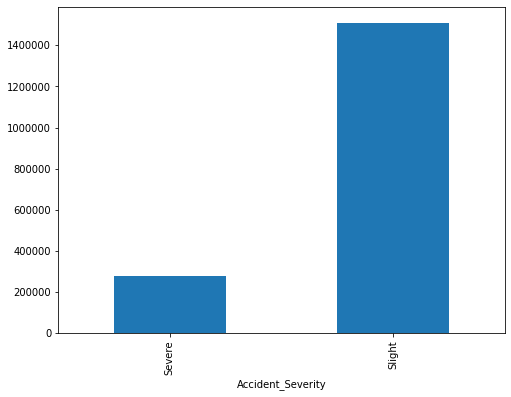

In [57]:
df_rf_2 = df_uk.copy()
# some modifications for label encoding
df_rf_2['Speed_limit'] = df_rf_2['Speed_limit'].astype(int)
df_rf_2['Engine_Capacity_(CC)'] = df_rf_2['Engine_Capacity_(CC)'].astype(int)
df_rf_2['Age_of_Vehicle'] = df_rf_2['Age_of_Vehicle'].astype(int)
df_rf_2['1st_Point_of_Impact'] = df_rf_2['1st_Point_of_Impact'].replace(0.0, 'No impact')
df_rf_2['Accident_Severity'] = df_rf_2['Accident_Severity'].replace('Serious', 'Severe')
df_rf_2['Accident_Severity'] = df_rf_2['Accident_Severity'].replace('Fatal', 'Severe')

In [58]:
c = Counter(df_rf_2['Accident_Severity'])
[(i, c[i] / len(df_rf_2['Accident_Severity']) * 100.0) for i in c]

[('Severe', 15.47738586587232), ('Slight', 84.52261413412768)]

In [33]:
#Labelling categorical features
lblE = LabelEncoder()
for i in df_rf_2:
    if df_rf_2[i].dtype == 'object':
        lblE.fit(df_rf_2[i])
        df_rf_2[i] = lblE.transform(df_rf_2[i])

In [34]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_rf_2.drop('Accident_Severity', axis=1), 
                                                    df_rf_2.Accident_Severity, test_size=0.33, random_state=42)
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

((1197039, 23), (589587, 23), (1197039,), (589587,))

In [21]:
rf_2 = RandomForestClassifier(n_estimators=50)
rf_2.fit(X_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
print("Train score "+ str(rf_2.score(X_train_2, y_train_2)))
print("Test score "+ str(rf_2.score(X_test_2, y_test_2)))

Train score 0.9988271058837682
Test score 0.8804603900696589


In [23]:
n_nodes = []
max_depths = []

for ind_tree in rf_2.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 431607
Average maximum depth 62


In [24]:
accuracy_rf_2 = cross_val_score(rf_2, X_train_2, y_train_2, scoring='accuracy')
print(accuracy_rf_2)

[0.87686293 0.87665826 0.87697571 0.87680445 0.87636535]


In [25]:
y_pred_rf_2 = rf_2.predict(X_test_2)
print(metrics.classification_report(y_test_2, y_pred_rf_2))

              precision    recall  f1-score   support

           0       0.78      0.32      0.45     91747
           1       0.89      0.98      0.93    497840

    accuracy                           0.88    589587
   macro avg       0.84      0.65      0.69    589587
weighted avg       0.87      0.88      0.86    589587



In [26]:
f_imp_2 = pd.DataFrame(data={'importance':rf_2.feature_importances_,'features':X_train_2.columns}).set_index('features')
f_imp_2 = f_imp_2.sort_values('importance', ascending=False)
f_imp_2

,importance
features,
Engine_Capacity_(CC),0.184384
Age_of_Vehicle,0.139076
Day_of_Week,0.092997
Age_Band_of_Driver,0.080100
Vehicle_Manoeuvre,0.061344
Number_of_Casualties,0.054449
1st_Point_of_Impact,0.046855
Number_of_Vehicles,0.041793
1st_Road_Class,0.038058


## Random Forest - 2 classes slight, severe- balanced

In [35]:
print(Counter(y_train_2))
print(Counter(y_test_2))

Counter({1: 1012263, 0: 184776})
Counter({1: 497840, 0: 91747})


In [36]:
rus = RandomUnderSampler(random_state=42)
X_res_train_2, y_res_train_2 = rus.fit_resample(X_train_2, y_train_2)
X_res_test_2, y_res_test_2 = rus.fit_resample(X_test_2, y_test_2)

In [37]:
print(Counter(y_res_train_2))
print(Counter(y_res_test_2))
# total records = 276523, equally distributed classes

Counter({0: 184776, 1: 184776})
Counter({0: 91747, 1: 91747})


In [38]:
rf_res_2 = RandomForestClassifier(n_estimators=50)
rf_res_2.fit(X_res_train_2, y_res_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
print("Train score "+ str(rf_res_2.score(X_res_train_2, y_res_train_2)))
print("Test score "+ str(rf_res_2.score(X_res_test_2, y_res_test_2)))

Train score 0.999253149759709
Test score 0.7042192115273523


In [40]:
n_nodes = []
max_depths = []

for ind_tree in rf_res_2.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 212431
Average maximum depth 56


In [41]:
accuracy_res_rf_2 = cross_val_score(rf_res_2, X_res_train_2, y_res_train_2, scoring='accuracy')
print(accuracy_res_rf_2)

[0.69981464 0.69819107 0.69834934 0.69801109 0.69755108]


In [42]:
y_res_pred_rf_2 = rf_res_2.predict(X_res_test_2)
print(metrics.classification_report(y_res_test_2, y_res_pred_rf_2))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71     91747
           1       0.71      0.70      0.70     91747

    accuracy                           0.70    183494
   macro avg       0.70      0.70      0.70    183494
weighted avg       0.70      0.70      0.70    183494



In [43]:
f_res_imp_2 = pd.DataFrame(data={'importance':rf_res_2.feature_importances_,'features':X_res_train_2.columns}).set_index('features')
f_res_imp_2 = f_res_imp_2.sort_values('importance', ascending=False)
f_res_imp_2

,importance
features,
Engine_Capacity_(CC),0.164214
Age_of_Vehicle,0.125550
Day_of_Week,0.085836
Age_Band_of_Driver,0.077059
Vehicle_Manoeuvre,0.071134
1st_Point_of_Impact,0.062993
Number_of_Casualties,0.054869
Number_of_Vehicles,0.049742
1st_Road_Class,0.037799


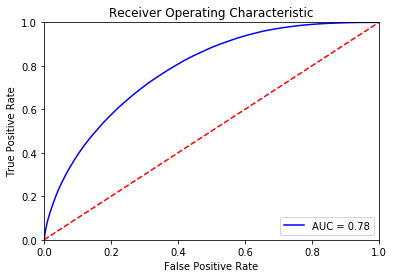

In [36]:
probs = rf_res_2.predict_proba(X_res_test_2)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_res_test_2, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Feature Selection

In [44]:
sel = SelectFromModel(rf_res_2)
sel.fit(X_res_train_2, y_res_train_2)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=50, n_jobs=None,
                                                 oob_score=False,


In [46]:
selected_feat= X_res_train_2.columns[(sel.get_support())]
print(selected_feat)

Index(['Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week',
       'Vehicle_Manoeuvre', '1st_Point_of_Impact', 'Engine_Capacity_(CC)',
       'Age_of_Vehicle', 'Age_Band_of_Driver'],
      dtype='object')


In [51]:
X_important_train = sel.transform(X_res_train_2)
X_important_test = sel.transform(X_res_test_2)
rf_res_2_important = RandomForestClassifier(n_estimators=50)
rf_res_2_important.fit(X_important_train, y_res_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
print("Train score "+ str(rf_res_2_important.score(X_important_train, y_res_train_2)))
print("Test score "+ str(rf_res_2_important.score(X_important_test, y_res_test_2)))

Train score 0.9744772048317963
Test score 0.6522120614298015


In [53]:
y_res_pred_rf_2_important = rf_res_2_important.predict(X_important_test)
print(metrics.classification_report(y_res_test_2, y_res_pred_rf_2_important))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66     91747
           1       0.66      0.63      0.64     91747

    accuracy                           0.65    183494
   macro avg       0.65      0.65      0.65    183494
weighted avg       0.65      0.65      0.65    183494



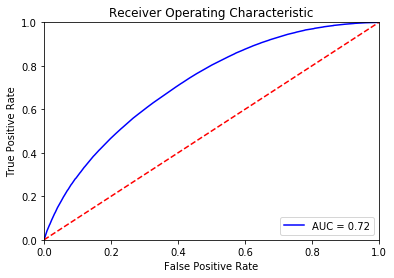

In [54]:
probs = rf_res_2_important.predict_proba(X_important_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_res_test_2, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()